# ModelNet10 U-net code for 3D object reconstruction

This notebook converts the ModelNet database into Voxel data and then trains a U-Net for reconstruction of noisy, sliced data to be reconstructed back to the original voxel data.

The ModelNet10 Database was used for this code. The code can be trained on a single class, which is then used to reconstruct the objects.

This notebook was made by Ian MacLeod for the Advanced Machine Learning course (TIF360) at Chalmers University of Technology.

In order to use this code, please reference the GitHub repository.

## All imports

In [ ]:
import os
import numpy as np
import trimesh

from pathlib import Path

import open3d as o3d
import colorsys
from scipy import ndimage

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## File conversion

In [ ]:
import os
import numpy as np
import trimesh

def read_off_file(file_path):
    """Read OFF file and return vertices and faces."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    # Skip header
    if lines[0].strip() == 'OFF':
        lines = lines[1:]
        
    # Get counts
    n_verts, n_faces, _ = map(int, lines[0].strip().split())
    
    # Read vertices
    vertices = np.array([list(map(float, line.strip().split())) 
                        for line in lines[1:n_verts+1]])
    
    # Read faces
    faces = np.array([list(map(int, line.strip().split()))[1:] 
                     for line in lines[n_verts+1:n_verts+n_faces+1]])
    
    return vertices, faces

def normalize_mesh(mesh):
    """Center and scale mesh to unit cube."""
    # Center the mesh
    center = mesh.bounds.mean(axis=0)
    mesh.apply_translation(-center)
    
    # Scale to unit cube
    scale = 1.0 / np.max(mesh.bounds[1] - mesh.bounds[0])
    mesh.apply_scale(scale)
    
    return mesh

def voxelize_mesh(mesh, resolution=32):
    """Convert mesh to voxel grid."""
    # Sample points on the surface
    points = mesh.sample(resolution**3)
    
    # Create voxel grid
    voxels = np.zeros((resolution, resolution, resolution), dtype=bool)
    
    # Scale points to voxel coordinates
    points = (points + 0.5) * resolution
    points = points.astype(int)
    
    # Clip to valid voxel coordinates
    points = np.clip(points, 0, resolution-1)
    
    # Mark occupied voxels
    voxels[points[:,0], points[:,1], points[:,2]] = True
    
    return voxels

# # This takes a MUCH longer time but should yield better results
# # However, this is unrealistic to the point cloud data given by
# # LiDAR data.
# def voxelize_mesh(mesh, resolution=32):
#     """
#     Convert mesh to voxel grid with filled interior.
#     Args:
#         mesh: Trimesh object
#         resolution: Grid resolution
#     Returns:
#         Voxel grid with surface and interior marked as True
#     """
#     # Sample points on the surface
#     points = mesh.sample(resolution**3)
    
#     # Create voxel grid
#     voxels = np.zeros((resolution, resolution, resolution), dtype=bool)
    
#     # Scale points to voxel coordinates
#     points = (points + 0.5) * resolution
#     points = points.astype(int)
    
#     # Clip to valid voxel coordinates
#     points = np.clip(points, 0, resolution-1)
    
#     # Mark surface voxels
#     voxels[points[:,0], points[:,1], points[:,2]] = True
    
#     # Create grid of all points
#     x, y, z = np.meshgrid(
#         np.arange(resolution),
#         np.arange(resolution),
#         np.arange(resolution),
#         indexing='ij'
#     )
#     grid_points = np.stack([x, y, z], axis=-1)
    
#     # Scale grid points back to mesh coordinates
#     grid_points = (grid_points / resolution) - 0.5
    
#     # Check which points are inside the mesh using trimesh
#     points_inside = mesh.contains(grid_points.reshape(-1, 3))
    
#     # Reshape back to grid and combine with surface points
#     interior = points_inside.reshape(resolution, resolution, resolution)
#     voxels = np.logical_or(voxels, interior)
    
#     return voxels

In [ ]:
from pathlib import Path

def convert_off_to_voxel(input_dir, base_output_dir, resolution=32):
    """
    Convert all OFF files in input directory to voxel representations of "resolution=n" n by n by n
        .npy files.
    Saves in a top-level 'voxel{resolution}' directory while maintaining subdirectory structure.
    For the rest of the code to work, use the folder structure as specified in the VoxelDataset
        comment. The dataset folder structure is designed to work with ModelNet10 dataset.
    However, as long as the Dataset code is modified for different folder structures, the code 
        should work for other folder structures.

    If the folder directories already exist with the "voxel<resolution>" name, this 
        function will skip conversion.
    """

    # Create output directory with resolution in name
    output_path = Path(base_output_dir) / f"voxel{resolution}"

    # Check if directory already exists
    if output_path.exists():
        print(f"Directory {output_path} already exists. Skipping conversion.")
        return
    
    input_path = Path(input_dir)
    
    # Create output directory if it doesn't exist
    output_path.mkdir(parents=True, exist_ok=False)
    
    # Walk through all directories
    for root, dirs, files in os.walk(input_path):
        # Create corresponding output directory
        rel_path = Path(root).relative_to(input_path)
        current_output_dir = output_path / rel_path
        current_output_dir.mkdir(parents=True, exist_ok=True)
        
        # Process OFF files
        for file in files:
            if file.lower().endswith('.off'):
                input_file = Path(root) / file
                output_file = current_output_dir / f"{file[:-4]}.npy"
                
                try:
                    # Read OFF file
                    vertices, faces = read_off_file(input_file)
                    
                    # Create mesh
                    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
                    
                    # Normalize mesh
                    mesh = normalize_mesh(mesh)
                    
                    # Convert to voxels
                    voxels = voxelize_mesh(mesh, resolution)
                    
                    # Save voxel grid
                    np.save(output_file, voxels)
                    # print(f"Converted {input_file} -> {output_file}")
                    
                except Exception as e:
                    print(f"Error processing {input_file}: {str(e)}")

if __name__ == "__main__":
    # Usage
    input_directory = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/ModelNet10"
    output_directory = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder"
    convert_off_to_voxel(input_directory, output_directory, resolution=60)

Directory C:\Users\naido\Documents\ChalmersCourses\AML\Project\Code\Autoencoder\voxel60 already exists. Skipping conversion.


## Visualization

Open 3d version (single color)

In [3]:
# import open3d as o3d

# def visualize_voxel_o3d(voxel_file):
#     """
#     Load and visualize a voxel file using Open3D
#     Args:
#         voxel_file (str or Path): Path to .npy voxel file
#     """
#     # Load the voxel data
#     voxels = np.load(voxel_file)
    
#     # Create an Open3D VoxelGrid
#     voxel_grid = o3d.geometry.VoxelGrid()
    
#     # Get indices of occupied voxels
#     occupied_voxels = np.where(voxels)
#     voxel_indices = np.column_stack(occupied_voxels)
    
#     # Create voxels with unit size
#     voxel_size = 1.0
#     voxel_points = voxel_indices.astype(float) * voxel_size
    
#     # Create point cloud from voxel centers
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(voxel_points)
    
#     # Create voxel grid from point cloud
#     voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size)
    
#     # Visualize
#     o3d.visualization.draw_geometries([voxel_grid])

# # Example usage
# input_directory = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/ModelNet10"
# output_directory = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder"
# resolution = 60

# # Example visualization of a specific voxel file
# voxel_file = Path(output_directory) / f"voxel{resolution}" / "chair" / "train" / "chair_0001.npy"
# if voxel_file.exists():
#     visualize_voxel_o3d(voxel_file)
# else:
#     print(f"File not found: {voxel_file}")

open3d version (multicolor)

In [4]:
import open3d as o3d
import colorsys
from scipy import ndimage

def visualize_voxel_o3d(voxels, remove_disconnected=True):
    """
    Visualize voxel data using Open3D with colored boxes, optionally removing disconnected components
    
    Args:
        voxels: Either a file path to .npy file or a numpy array containing voxel data
        remove_disconnected: If True, only show the largest connected component
    """
    # Handle input type
    if isinstance(voxels, (str, bytes, os.PathLike)):
        voxels = np.load(voxels)
    
    if remove_disconnected:
        # Find connected components
        structure = ndimage.generate_binary_structure(3, 3)  # 3D connectivity
        labeled_array, num_features = ndimage.label(voxels, structure=structure)
        
        if num_features > 0:
            # Find sizes of all connected components
            component_sizes = np.bincount(labeled_array.ravel())[1:]
            # Get the label of the largest component (add 1 because background is 0)
            largest_component = np.argmax(component_sizes) + 1
            # Create mask of largest component
            voxels = (labeled_array == largest_component)
    
    # Create list to store all boxes
    boxes = []
    
    # Create color palette using HSV color space for better distinction
    n_colors = 6  # Number of different colors to cycle through
    colors = []
    for i in range(n_colors):
        hue = i / n_colors
        # Convert HSV to RGB (using full saturation and value)
        if hue >= 1.0: hue -= 1.0
        c = colorsys.hsv_to_rgb(hue, 0.8, 0.8)
        colors.append(c)
    
    # Create a box for each occupied voxel
    for x, y, z in zip(*np.where(voxels)):
        # Create a box mesh
        box = o3d.geometry.TriangleMesh.create_box(width=1.0, height=1.0, depth=1.0)
        
        # Move box to correct position
        box.translate([x, y, z])
        
        # Assign color based on position
        color_idx = (x + y + z) % n_colors
        box.paint_uniform_color(colors[color_idx])
        
        boxes.append(box)
    
    if boxes:
        # Combine all boxes into a single mesh for efficient rendering
        combined_mesh = boxes[0]
        for box in boxes[1:]:
            combined_mesh += box
        
        # Create coordinate frame for reference
        coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
            size=5, origin=[0, 0, 0])
        
        # Visualize
        o3d.visualization.draw_geometries(
            [combined_mesh, coord_frame],
            window_name="Voxel Visualization",
            width=800,
            height=800,
            point_show_normal=False,
            mesh_show_wireframe=True,
            mesh_show_back_face=True
        )
    else:
        print("No voxels found in the data.")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


open3d with internal included

In [5]:
# def visualize_voxel_o3d(voxels):
#     """
#     Visualize voxel data using Open3D with colored boxes, showing all occupied voxels.
#     Args:
#         voxels: Either a file path to .npy file or a numpy array containing voxel data
#     """
#     # Handle input type
#     if isinstance(voxels, (str, bytes, os.PathLike)):
#         voxels = np.load(voxels)
    
#     # Create list to store all boxes
#     boxes = []
    
#     # Create color palette using HSV color space for better distinction
#     n_colors = 6  # Number of different colors to cycle through
#     colors = []
#     for i in range(n_colors):
#         hue = i / n_colors
#         if hue >= 1.0: hue -= 1.0
#         c = colorsys.hsv_to_rgb(hue, 0.8, 0.8)
#         colors.append(c)
    
#     # Create boxes for all occupied voxels
#     occupied_positions = np.where(voxels)
#     for x, y, z in zip(*occupied_positions):
#         # Create a box mesh
#         box = o3d.geometry.TriangleMesh.create_box(width=1.0, height=1.0, depth=1.0)
        
#         # Move box to correct position
#         box.translate([x, y, z])
        
#         # Assign color based on position in 3D space
#         color_idx = (x + y + z) % n_colors
#         box.paint_uniform_color(colors[color_idx])
        
#         boxes.append(box)
    
#     if boxes:
#         # Combine all boxes into a single mesh for efficient rendering
#         combined_mesh = boxes[0]
#         for box in boxes[1:]:
#             combined_mesh += box
        
#         # Create coordinate frame for reference
#         coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
#             size=5, origin=[0, 0, 0])
        
#         # Visualize with wireframe to see internal structure
#         o3d.visualization.draw_geometries(
#             [combined_mesh, coord_frame],
#             window_name="Voxel Visualization",
#             width=800,
#             height=800,
#             point_show_normal=False,
#             mesh_show_wireframe=True,
#             mesh_show_back_face=True,
#         )
#     else:
#         print("No voxels found in the data.")

## Data loading

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path

class VoxelDataset(Dataset):
    """Custom Dataset for loading voxel data"""
    def __init__(self, data_dir, split='train', class_name=None):
        """
        Expected directory format: 
            Top folder named "voxel<insertresolutionhere>" Ex. voxel60
            Sub-folders of the class names (only trains on 1, but this mimics 
                ModelNet database folder structure for simplicity)
            Inside each sub-folder are the 'train' and 'test' folders, which contain
                the models as .npy files, which are n by n by n binary voxels. This 
                can be generated by the file conversion functions above. 
        Args:
            data_dir (str): Path to the voxel directory containing class folders
            split (str): 'train' or 'test'
            class_name (str, optional): If provided, only load data from this class
        """
        self.data_dir = Path(data_dir)
        self.split = split
        
        # Get all class directories or filter for specific class
        if class_name:
            class_dir = self.data_dir / class_name
            if not class_dir.exists():
                raise ValueError(f"Class directory '{class_name}' not found in {data_dir}")
            self.classes = [class_name]
        else:
            self.classes = sorted([d.name for d in self.data_dir.iterdir() if d.is_dir()])
        
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        # Get all .npy files in the split directories under each class
        self.file_paths = []
        for class_name in self.classes:
            class_split_dir = self.data_dir / class_name / split
            if class_split_dir.exists():
                self.file_paths.extend(list(class_split_dir.glob('*.npy')))
            else:
                print(f"Warning: Directory {class_split_dir} not found")
        
        if len(self.file_paths) == 0:
            raise ValueError(f"No data files found for split '{split}'")
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load voxel data
        voxel_path = self.file_paths[idx]
        voxel_data = np.load(voxel_path)
        
        # Convert to tensor
        voxel_tensor = torch.from_numpy(voxel_data).float()
        voxel_tensor = voxel_tensor.unsqueeze(0)  # Add channel dimension
        
        # Get class label from grandparent directory name (class folder)
        class_name = voxel_path.parent.parent.name
        class_idx = self.class_to_idx[class_name]
        class_tensor = torch.tensor(class_idx, dtype=torch.long)
        
        return voxel_tensor, class_tensor

def get_dataloaders(data_dir, batch_size=32, num_workers=0, class_name=None):
    """
    Create train and test dataloaders
    
    Args:
        data_dir (str): Path to data directory containing train/test folders
        batch_size (int): Batch size for training
        num_workers (int): Number of workers for data loading (set to 0 for .ipynb)
        class_name (str, optional): If provided, only load data from this class
    
    Returns:
        train_loader, test_loader: DataLoader objects for training and testing
    """
    # Create datasets
    train_dataset = VoxelDataset(data_dir, split='train', class_name=class_name)
    test_dataset = VoxelDataset(data_dir, split='test', class_name=class_name)
    
    print(f"Loading data for {'all classes' if class_name is None else f'class: {class_name}'}")
    print(f"Found {len(train_dataset)} training samples")
    print(f"Found {len(test_dataset)} test samples")
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, test_loader

# # Example usage:
# if __name__ == "__main__":
#     voxel_dir = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60"
    
#     # Load all classes
#     train_loader, test_loader = get_dataloaders(voxel_dir, batch_size=32)
    
#     # Or load specific class
#     chair_train_loader, chair_test_loader = get_dataloaders(
#         voxel_dir, 
#         batch_size=32, 
#         class_name="chair"
#     )

In [7]:
# train_loader, test_loader = get_dataloaders("C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60", batch_size=32)

# for epoch in range(num_epochs):
#     for data, labels in train_loader:
#         # data shape: [batch_size, 1, resolution, resolution, resolution]
#         # labels shape: [batch_size]
#         ...

## Transformations

In [ ]:
# def apply_noise_to_voxels(voxel_tensor, dropout_prob=0.1, expansion_prob=0.05):
#     """
#     Apply noise to voxels:
#     - Randomly remove some occupied voxels
#     - Randomly expand occupied regions
    
#     Args:
#         voxel_tensor (torch.Tensor): Input tensor of shape [B, 1, D, H, W]
#         dropout_prob (float): Probability of removing an occupied voxel
#         expansion_prob (float): Probability of adding voxels near occupied ones
#     """
#     B, C, D, H, W = voxel_tensor.shape
#     noisy_tensor = voxel_tensor.clone()
    
#     for b in range(B):
#         # Get occupied voxel positions
#         occupied = torch.where(voxel_tensor[b, 0] > 0)
        
#         # Randomly remove some occupied voxels
#         dropout_mask = torch.rand_like(voxel_tensor[b, 0]) > dropout_prob
#         noisy_tensor[b, 0] = noisy_tensor[b, 0] * dropout_mask
        
#         # Expand around occupied voxels
#         for x, y, z in zip(*occupied):
#             # Check 6-neighborhood
#             neighbors = [
#                 (x+1, y, z), (x-1, y, z),
#                 (x, y+1, z), (x, y-1, z),
#                 (x, y, z+1), (x, y, z-1)
#             ]
            
#             for nx, ny, nz in neighbors:
#                 if (0 <= nx < D and 0 <= ny < H and 0 <= nz < W and 
#                     not noisy_tensor[b, 0, nx, ny, nz] and 
#                     torch.rand(1) < expansion_prob):
#                     noisy_tensor[b, 0, nx, ny, nz] = 1
                    
#     return noisy_tensor
def apply_noise_to_voxels(voxel_tensor, dropout_prob=0.05, expansion_prob=0.05):
    """
    Apply noise to voxels using vectorized operations. Dropout is likelyhood of 
    turning off a voxel that is on in the original model. Expansion is likely-
    hood of turning on a voxel along the surface that is off in the original 
    model.

    Args:
        voxel_tensor (torch.Tensor): Input tensor of shape [B, 1, D, H, W]
        dropout_prob (float): Probability of removing an occupied voxel
        expansion_prob (float): Probability of adding voxels near occupied ones

    Returns:
        noisy_tensor (torch.Tensor): Noisy tensor of shape [B, 1, D, H, W]
    """
    device = voxel_tensor.device
    noisy_tensor = voxel_tensor.clone()
    
    # Vectorized dropout
    dropout_mask = (torch.rand_like(voxel_tensor, device=device) > dropout_prob).float()
    noisy_tensor = noisy_tensor * dropout_mask
    
    # Efficient expansion using convolution
    kernel = torch.zeros((1, 1, 3, 3, 3), device=device)
    kernel[..., 1, 1, 0] = 1
    kernel[..., 1, 1, 2] = 1
    kernel[..., 1, 0, 1] = 1
    kernel[..., 1, 2, 1] = 1
    kernel[..., 0, 1, 1] = 1
    kernel[..., 2, 1, 1] = 1
    
    # Find potential expansion locations
    neighbors = torch.nn.functional.conv3d(
        noisy_tensor.float(),
        kernel,
        padding=1
    )
    
    # Random expansion
    expansion_mask = (
        (neighbors > 0) & 
        (noisy_tensor == 0) & 
        (torch.rand_like(noisy_tensor, device=device) < expansion_prob)
    ).float()
    
    # Add expansion mask (using addition instead of OR)
    noisy_tensor = torch.clamp(noisy_tensor + expansion_mask, 0, 1)
    
    return noisy_tensor

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# def apply_random_plane_cut(voxel_tensor, max_cut_ratio=0.2):
#     """
#     Apply a random planar cut to the voxel data using arbitrary 3D rotation
    
#     Args:
#         voxel_tensor (torch.Tensor): Input tensor of shape [B, 1, D, H, W]
#         max_cut_ratio (float): Maximum fraction of volume to cut (0-1)
#     """
#     B, C, D, H, W = voxel_tensor.shape
#     cut_tensor = voxel_tensor.clone()
    
#     for b in range(B):
#         # Generate random rotation angles in radians
#         alpha = np.random.uniform(-np.pi, np.pi)  # rotation around x
#         beta = np.random.uniform(-np.pi, np.pi)   # rotation around y
#         gamma = np.random.uniform(-np.pi, np.pi)  # rotation around z
        
#         # Create 3D rotation matrices
#         Rx = torch.tensor([
#             [1, 0, 0],
#             [0, np.cos(alpha), -np.sin(alpha)],
#             [0, np.sin(alpha), np.cos(alpha)]
#         ], dtype=torch.float32)
        
#         Ry = torch.tensor([
#             [np.cos(beta), 0, np.sin(beta)],
#             [0, 1, 0],
#             [-np.sin(beta), 0, np.cos(beta)]
#         ], dtype=torch.float32)
        
#         Rz = torch.tensor([
#             [np.cos(gamma), -np.sin(gamma), 0],
#             [np.sin(gamma), np.cos(gamma), 0],
#             [0, 0, 1]
#         ], dtype=torch.float32)
        
#         # Combine rotations
#         R = Rz @ Ry @ Rx
        
#         # Random cut position
#         max_cut = int(max_cut_ratio * D)
#         cut_pos = np.random.randint(D - max_cut, D)
        
#         # Create cutting plane mask
#         mask = torch.ones((D, H, W), dtype=torch.bool)
#         center = torch.tensor([D/2, H/2, W/2])
        
#         # Apply rotated cut to each voxel
#         for i in range(D):
#             for j in range(H):
#                 for k in range(W):
#                     # Get point relative to center
#                     point = torch.tensor([i, j, k]) - center
                    
#                     # Rotate point
#                     rotated = R @ point
                    
#                     # Cut based on z-coordinate of rotated point
#                     if rotated[2] + center[2] > cut_pos:
#                         mask[i, j, k] = False
        
#         # Apply mask to current batch item
#         cut_tensor[b, 0] = cut_tensor[b, 0] * mask
    
#     return cut_tensor

def apply_random_plane_cut(voxel_tensor, min_cut_ratio=0.1, max_cut_ratio=0.2, max_attempts=50):
    """
    Apply a random planar cut that removes at least min_cut_ratio of occupied voxels and no more
    than max_cut_ratio. Checks the cut post cut. Attempts 50 times - if it fails, then it sends
    the entire model instead, which is good for training.
    """
    B, C, D, H, W = voxel_tensor.shape
    device = voxel_tensor.device
    cut_tensor = voxel_tensor.clone()
    
    # Pre-compute rotation matrices for efficiency
    angles = torch.rand((B, 3), device=device) * 2 * np.pi - np.pi
    
    for b in range(B):
        alpha, beta, gamma = angles[b]
        
        # Create 3D rotation matrices efficiently using torch operations
        Rx = torch.tensor([
            [1, 0, 0],
            [0, torch.cos(alpha), -torch.sin(alpha)],
            [0, torch.sin(alpha), torch.cos(alpha)]
        ], device=device)
        
        Ry = torch.tensor([
            [torch.cos(beta), 0, torch.sin(beta)],
            [0, 1, 0],
            [-torch.sin(beta), 0, torch.cos(beta)]
        ], device=device)
        
        Rz = torch.tensor([
            [torch.cos(gamma), -torch.sin(gamma), 0],
            [torch.sin(gamma), torch.cos(gamma), 0],
            [0, 0, 1]
        ], device=device)
        
        # Combine rotations
        R = Rz @ Ry @ Rx
        
        # Create coordinate grid once
        x, y, z = torch.meshgrid(
            torch.arange(D, device=device),
            torch.arange(H, device=device),
            torch.arange(W, device=device),
            indexing='ij'
        )
        points = torch.stack([x-D/2, y-H/2, z-W/2])
        points = points.reshape(3, -1)
        
        best_mask = None
        best_cut_ratio = 0
        
        # Try different cut positions to achieve minimum cut ratio
        for _ in range(max_attempts):
            # Random cut position
            cut_pos = torch.randint(
                int((1-max_cut_ratio)*D), D,
                (1,), device=device
            )
            
            # Rotate all points at once
            rotated_points = R @ points
            
            # Create mask based on rotated z-coordinate
            mask = (rotated_points[2] + D/2 <= cut_pos).reshape(D, H, W)
            
            # Calculate cut ratio of occupied voxels
            occupied_voxels = voxel_tensor[b, 0] > 0
            mask_float = mask.float()
            occupied_float = occupied_voxels.float()
            cut_ratio = 1 - ((mask_float * occupied_float).sum() / occupied_float.sum())
            
            if cut_ratio >= min_cut_ratio and cut_ratio <= max_cut_ratio:
                best_mask = mask_float
                break
            elif cut_ratio > best_cut_ratio:
                best_mask = mask_float
                best_cut_ratio = cut_ratio
        
        # Apply best mask found
        if best_mask is not None:
            cut_tensor[b, 0] = cut_tensor[b, 0] * best_mask
    
    return cut_tensor

## UNET

In [10]:
class VoxelUNetAutoencoder(nn.Module):
    def __init__(self, resolution=60, latent_dim=16):
        super().__init__()
        self.resolution = resolution
        self.latent_dim = latent_dim

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=4, stride=2, padding=1),  # 60->30
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1),  # 30->15
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # 15->8
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # 8->4
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2)
        )

        # Calculate flattened dimension
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, resolution, resolution, resolution)
            e1 = self.enc1(dummy_input)
            e2 = self.enc2(e1)
            e3 = self.enc3(e2)
            e4 = self.enc4(e3)
            self.flatten_dim = e4.numel() // e4.size(0)
            self.encoder_output_shape = e4.shape[1:]
            self.e1_shape = e1.shape[1:]
            self.e2_shape = e2.shape[1:]
            self.e3_shape = e3.shape[1:]

        # Latent space
        self.encoder_fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, latent_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, self.flatten_dim),
            nn.ReLU()
        )

        # Decoder with skip connections
        self.dec4 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),  # 4->8
            nn.BatchNorm3d(128),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose3d(256, 64, kernel_size=4, stride=2, padding=1),  # 8->15 (128 + 128 input)
            nn.BatchNorm3d(64),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose3d(128, 32, kernel_size=4, stride=2, padding=1),  # 15->30 (64 + 64 input)
            nn.BatchNorm3d(32),
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose3d(64, 1, kernel_size=4, stride=2, padding=1),  # 30->60 (32 + 32 input)
            nn.AdaptiveAvgPool3d((resolution, resolution, resolution))
        )

    def encode(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        flat = e4.view(e4.size(0), -1)
        z = self.encoder_fc(flat)
        return z, [e1, e2, e3, e4]

    def decode(self, z, enc_feats):
        e1, e2, e3, e4 = enc_feats
        x = self.decoder_fc(z)
        x = x.view(x.size(0), *self.encoder_output_shape)
        
        # Decoder path with size checking
        d4 = self.dec4(x)
        # Ensure d4 and e3 have same spatial dimensions
        d4 = torch.nn.functional.interpolate(d4, size=e3.shape[2:])
        d4_cat = torch.cat([d4, e3], dim=1)
        
        d3 = self.dec3(d4_cat)
        # Ensure d3 and e2 have same spatial dimensions
        d3 = torch.nn.functional.interpolate(d3, size=e2.shape[2:])
        d3_cat = torch.cat([d3, e2], dim=1)
        
        d2 = self.dec2(d3_cat)
        # Ensure d2 and e1 have same spatial dimensions
        d2 = torch.nn.functional.interpolate(d2, size=e1.shape[2:])
        d2_cat = torch.cat([d2, e1], dim=1)
        
        d1 = self.dec1(d2_cat)
        return d1

    def forward(self, x):
        input_size = x.shape
        z, enc_feats = self.encode(x)
        out = self.decode(z, enc_feats)
        assert out.shape == input_size, f"Output shape {out.shape} doesn't match input shape {input_size}"
        return out

In [11]:
# def calculate_class_weights(train_loader):
#     """Calculate inverse frequency weights for binary classes (0s and 1s)"""
#     total_ones = 0
#     total_pixels = 0
    
#     for data, _ in train_loader:
#         total_ones += torch.sum(data)
#         total_pixels += data.numel()
    
#     freq_1 = total_ones / total_pixels
#     freq_0 = 1 - freq_1
    
#     # Inverse frequency weighting
#     weight_0 = 1 / (freq_0 + 1e-5)
#     weight_1 = 1 / (freq_1 + 1e-5)
    
#     # Normalize weights
#     total = weight_0 + weight_1
#     weight_0 /= total
#     weight_1 /= total
    
#     return torch.tensor([weight_0, weight_1])

## Training setup

In [ ]:
from tqdm import tqdm

def train_autoencoder(model, train_loader, test_loader, num_epochs=1000, device="cuda"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=50,
    )
    
    # Create BCE loss with positive weight parameter
    pos_weight = torch.tensor([100.0]).to(device)  # Weight positive samples 100x more
    criterion = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)
    # # criterion=nn.BCEWithLogitsLoss()(torch.sigmoid())
    # # Track best model and early stopping
    best_val_loss = float('inf')
    best_model_state = None
    patience = 50
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), 
                   desc=f'Epoch {epoch}', leave=False)
        
        for batch_idx, (data, _) in pbar:
            data = data.to(device, non_blocking=True)
            
            # Apply transformations
            input_data = apply_random_plane_cut(
                apply_noise_to_voxels(data)
            ).to(device)
            
            # Forward pass with mixed precision
            # with torch.amp.autocast('cuda'):
            #     output = model(input_data)
            #     loss = criterion(output, data)
            #     weighted_loss = loss.mean()
            with torch.amp.autocast('cuda'):
                output = model(input_data)

            # Move loss calculation outside autocast
            loss = criterion(output, data)
            weighted_loss = loss.mean()
            
            # Backward pass
            optimizer.zero_grad(set_to_none=True)
            # Clip gradients to avoid extreme values
        
            weighted_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            
            train_loss += weighted_loss.item()
            pbar.set_postfix({'loss': weighted_loss.item()})
        
        # Validation
        if epoch % 2 == 0:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, _ in test_loader:
                    data = data.to(device, non_blocking=True)
                    input_data = apply_random_plane_cut(
                        apply_noise_to_voxels(data)
                    ).to(device)
                    
                    with torch.amp.autocast('cuda'):
                        output = model(input_data)
                        loss = criterion(output, data)
                        val_loss += loss.mean().item()
            
            avg_val_loss = val_loss/len(test_loader)
            scheduler.step(avg_val_loss)
            
            # Save best model and early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break
            
            print(f'Epoch {epoch}: Train Loss = {train_loss/len(train_loader):.4f}, '
                  f'Val Loss = {avg_val_loss:.4f}')
    
    return best_model_state, best_val_loss

# def train_autoencoder(model, train_loader, test_loader, num_epochs=100, device="cuda"):
#     model = model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode='min', factor=0.5, patience=5,
#     )
    
#     # Use L1 loss
#     criterion = nn.L1Loss()
    
#     # Track best model and early stopping
#     best_val_loss = float('inf')
#     best_model_state = None
#     patience = 1000
#     patience_counter = 0
    
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0
        
#         pbar = tqdm(enumerate(train_loader), total=len(train_loader), 
#                    desc=f'Epoch {epoch}', leave=False)
        
#         for batch_idx, (data, _) in pbar:
#             data = data.to(device, non_blocking=True)
            
#             # Apply transformations
#             input_data = apply_random_plane_cut(
#                 apply_noise_to_voxels(data)
#             ).to(device)
            
#             # Forward pass with mixed precision
#             with torch.amp.autocast('cuda'):
#                 output = model(input_data)
#                 # Apply sigmoid to get values between 0 and 1
#                 output = torch.sigmoid(output)
#                 loss = criterion(output, data)
            
#             # Backward pass
#             optimizer.zero_grad(set_to_none=True)
#             loss.backward()
#             optimizer.step()
            
#             train_loss += loss.item()
#             pbar.set_postfix({'loss': loss.item()})
        
#         # Validation
#         if epoch % 2 == 0:
#             model.eval()
#             val_loss = 0
#             with torch.no_grad():
#                 for data, _ in test_loader:
#                     data = data.to(device, non_blocking=True)
#                     input_data = apply_random_plane_cut(
#                         apply_noise_to_voxels(data)
#                     ).to(device)
                    
#                     with torch.amp.autocast('cuda'):
#                         output = model(input_data)
#                         output = torch.sigmoid(output)
#                         val_loss += criterion(output, data).item()
            
#             avg_val_loss = val_loss/len(test_loader)
#             scheduler.step(avg_val_loss)
            
#             # Save best model and early stopping
#             if avg_val_loss < best_val_loss:
#                 best_val_loss = avg_val_loss
#                 best_model_state = model.state_dict()
#                 patience_counter = 0
#             else:
#                 patience_counter += 1
            
#             if patience_counter >= patience:
#                 print(f"\nEarly stopping at epoch {epoch}")
#                 break
            
#             print(f'Epoch {epoch}: Train Loss = {train_loss/len(train_loader):.4f}, '
#                   f'Val Loss = {avg_val_loss:.4f}')
    
#     return best_model_state, best_val_loss

Performance Improvements:

Added mixed precision training with torch.cuda.amp
Using non_blocking=True for asynchronous data transfer
More efficient gradient zeroing with set_to_none=True
Combined transformations to reduce memory operations
Training Enhancements:

Added learning rate scheduler with ReduceLROnPlateau
Implemented early stopping
Reduced validation frequency (every 2 epochs)
Added progress bar with tqdm
Memory Optimizations:

Pre-computed validation indices
Better memory management for transformations

In [ ]:
def visualize_reconstruction(model, test_loader, device="cuda", num_examples=5, skip=0):
    """
    Visualize original, cut, and reconstructed voxels
    
    Args:
        model: The trained model to use for reconstruction
        test_loader: DataLoader containing test data
        device: Device to run model on
        num_examples: Number of examples to visualize
        skip: Number of samples to skip before starting visualization
    """
    model.eval()
    
    with torch.no_grad():
        # Get iterator and skip desired number of samples
        data_iterator = iter(test_loader)
        for _ in range(skip):
            try:
                next(data_iterator)
            except StopIteration:
                print("Warning: Skip value larger than dataset. Starting from beginning.")
                data_iterator = iter(test_loader)
        
        # Get the samples to visualize
        data, _ = next(data_iterator)
        
        # Process only num_examples
        data = data[:num_examples].to(device)
        
        # Create cuts
        cut_data = apply_random_plane_cut(
            apply_noise_to_voxels(data)
        ).to(device)
        
        # Get reconstructions
        reconstructions = model(cut_data)
        
        # Move tensors to CPU and convert to numpy
        originals = data.cpu().numpy()
        cuts = cut_data.cpu().numpy()
        reconstructions = reconstructions.cpu().numpy()
        
        # Visualize each example
        for i in range(num_examples):
            print(f"\nExample {i+1} (after skipping {skip} samples)")
            
            # Original
            print("Original:")
            visualize_voxel_o3d(originals[i, 0])
            
            # Cut version
            print("Cut version:")
            visualize_voxel_o3d(cuts[i, 0])
            
            # Reconstruction
            print("Reconstruction:")
            # Threshold the reconstruction values
            recon_binary = reconstructions[i, 0] > 0.95  # Threshold logit confidence
            visualize_voxel_o3d(recon_binary)

In [14]:
# # L1loss version

# def visualize_reconstruction(model, test_loader, device="cuda", num_examples=5):
#     """Visualize original, cut, and reconstructed voxels"""
#     model.eval()
    
#     with torch.no_grad():
#         # Get some test examples
#         data_iterator = iter(test_loader)
#         data, _ = next(data_iterator)
        
#         # Process only num_examples
#         data = data[:num_examples].to(device)
        
#         # Create cuts
#         cut_data = apply_random_plane_cut(
#             apply_noise_to_voxels(data)
#         ).to(device)
        
#         # Get reconstructions (no sigmoid needed with L1Loss)
#         reconstructions = model(cut_data)
        
#         # Move tensors to CPU and convert to numpy
#         originals = data.cpu().numpy()
#         cuts = cut_data.cpu().numpy()
#         reconstructions = reconstructions.cpu().numpy()
        
#         # Visualize each example
#         for i in range(num_examples):
#             print(f"\nExample {i+1}")
            
#             # Original
#             print("Original:")
#             visualize_voxel_o3d(originals[i, 0])
            
#             # Cut version
#             print("Cut version:")
#             visualize_voxel_o3d(cuts[i, 0])
            
#             # Reconstruction
#             print("Reconstruction:")
#             # Threshold the reconstruction values (adjust threshold based on your data)
#             recon_binary = reconstructions[i, 0] > 0.5  # Adjust threshold if needed
#             visualize_voxel_o3d(recon_binary)

## Training

In [15]:

# Training and visualization
# Setup
resolution = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
train_loader, test_loader = get_dataloaders(
    "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60",
    batch_size=64, class_name="chair"
)

# Create model and train
model = VoxelUNetAutoencoder(resolution=resolution)
best_model_state, best_val_loss = train_autoencoder(
    model, 
    train_loader, 
    test_loader, 
    num_epochs=1000,
    device=device
)
    
# Save best model
save_path = Path("C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/best_model_uNet.pth")
torch.save({
    'model_state_dict': best_model_state,
    'val_loss': best_val_loss,
    'resolution': resolution
}, save_path)
print(f"\nBest model saved with validation loss: {best_val_loss:.4f}")
    
# Load best model for visualization
model.load_state_dict(best_model_state)

Loading data for class: chair
Found 889 training samples
Found 100 test samples


KeyboardInterrupt: 

In [ ]:
# Visualize some test examples
print("\nVisualizing test examples...")
train_loader, test_loader = get_dataloaders(
    "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60",
    batch_size=64, class_name="chair"
)
visualize_reconstruction(model, test_loader, device=device, num_examples=3)


Visualizing test examples...
Loading data for class: chair
Found 889 training samples
Found 100 test samples

Example 1
Original:
Cut version:
Reconstruction:

Example 2
Original:
Cut version:
Reconstruction:

Example 3
Original:
Cut version:
Reconstruction:


## testing

In [ ]:
# def visualize_transformations(data_loader, device="cpu", num_examples=3):
#     """
#     Visualize the data transformation pipeline:
#     1. Original data
#     2. After noise application
#     3. After planar cut
    
#     Args:
#         # data_loader: DataLoader containing te voxel data
#         device: Device to run computations on
#         num_examples: Number of examples to visualize
#     """
#     # Get some examples
#     data_iterator = iter(data_loader)
#     data, _ = next(data_iterator)
    
#     # Process only num_examples and move to device
#     data = data[:num_examples].to(device)
    
#     # Apply transformations (keeping on GPU)
#     noisy_data = apply_noise_to_voxels(data)
#     cut_data = apply_random_plane_cut(noisy_data)
    
#     # Move tensors to CPU all at once for visualization
#     originals = data.detach().cpu().numpy()
#     noisy = noisy_data.detach().cpu().numpy()
#     cuts = cut_data.detach().cpu().numpy()
    
#     # Visualize each example
#     for i in range(num_examples):
#         print(f"\nExample {i+1}")
        
#         # Original
#         print("Original:")
#         visualize_voxel_o3d(originals[i, 0])
        
#         # After noise
#         print("After noise application:")
#         visualize_voxel_o3d(noisy[i, 0])
        
#         # After cut
#         print("After planar cut:")
#         visualize_voxel_o3d(cuts[i, 0])

# # Usage
# if __name__ == "__main__":
#     train_loader_tester, test_loader_tester = get_dataloaders(
#         "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60",
#         batch_size=32
#     )
    
#     print("Visualizing transformation pipeline...")
#     visualize_transformations(test_loader, num_examples=3)

In [ ]:
import numpy as np
import colorsys
import open3d as o3d
from pathlib import Path

def load_and_visualize_sample(data_dir, class_name="chair", split="train", sample_idx=0):
    """
    Load and visualize a sample voxel file from the dataset
    
    Args:
        data_dir (str): Base directory containing voxel data
        class_name (str): Name of the class to load from
        split (str): 'train' or 'test' split
        sample_idx (int): Index of the sample to load
    
    Returns:
        np.ndarray: The loaded voxel array
    """
    # Construct path to class directory
    voxel_path = Path(data_dir) / class_name / split
    
    # Get all .npy files
    voxel_files = sorted(list(voxel_path.glob("*.npy")))
    
    if not voxel_files:
        raise ValueError(f"No voxel files found in {voxel_path}")
    
    if sample_idx >= len(voxel_files):
        print(f"Sample index {sample_idx} out of range. Using last sample.")
        sample_idx = len(voxel_files) - 1
    
    # Load the voxel data
    voxel_file = voxel_files[sample_idx]
    voxel_array = np.load(voxel_file)
    
    print(f"Loaded voxel file: {voxel_file.name}")
    print(f"Array shape: {voxel_array.shape}")
    print(f"Number of occupied voxels: {np.sum(voxel_array)}")
    
    # Visualize the voxel data
    print("\nVisualizing voxel data:")
    visualize_voxel_o3d(voxel_array)
    
    return voxel_array

# # Usage
# if __name__ == "__main__":
#     data_dir = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60"
#     sample = load_and_visualize_sample(
#         data_dir=data_dir,
#         class_name="chair",
#         split="train",
#         sample_idx=0
#     )

In [19]:
def load_and_visualize_model(model_path, data_dir, class_name=None, num_examples=3, device="cuda"):
    """
    Load a saved model and visualize random test samples
    
    Args:
        model_path (str or Path): Path to the saved model file
        data_dir (str or Path): Path to the voxel data directory
        class_name (str, optional): If provided, only load data from this class
        num_examples (int): Number of examples to visualize
        device (str): Device to run the model on
    """
    # Load the saved model
    checkpoint = torch.load(model_path, map_location=device)
    resolution = checkpoint['resolution']
    
    # Create and load model
    model = VoxelUNetAutoencoder(resolution=resolution)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Loaded model with validation loss: {checkpoint['val_loss']:.4f}")
    
    # Get test data
    _, test_loader = get_dataloaders(
        data_dir,
        batch_size=num_examples,
        class_name=class_name
    )
    
    # Visualize reconstructions
    visualize_reconstruction(model, test_loader, device=device, num_examples=num_examples, skip=16)
    # good examples: 51(back reconstruction), 3(hard half seat), 4(classic), 5(big), 7(snake), 10(armrest)
    # 13(lounge), 
    
# Example usage
if __name__ == "__main__":
    model_path = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/best_model_uNet_chairs_bcelogits.pth"
    data_dir = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60"
    
    print("Loading model and visualizing random test samples...")
    load_and_visualize_model(
        model_path=model_path,
        data_dir=data_dir,
        class_name="chair",  # Optional: specify class
        num_examples=1
    )

Loading model and visualizing random test samples...
Loaded model with validation loss: 0.1546
Loading data for class: chair
Found 889 training samples
Found 100 test samples

Example 1 (after skipping 16 samples)
Original:
Cut version:
Reconstruction:


Loading data for class: chair_samples
Found 1 training samples
Found 1 test samples


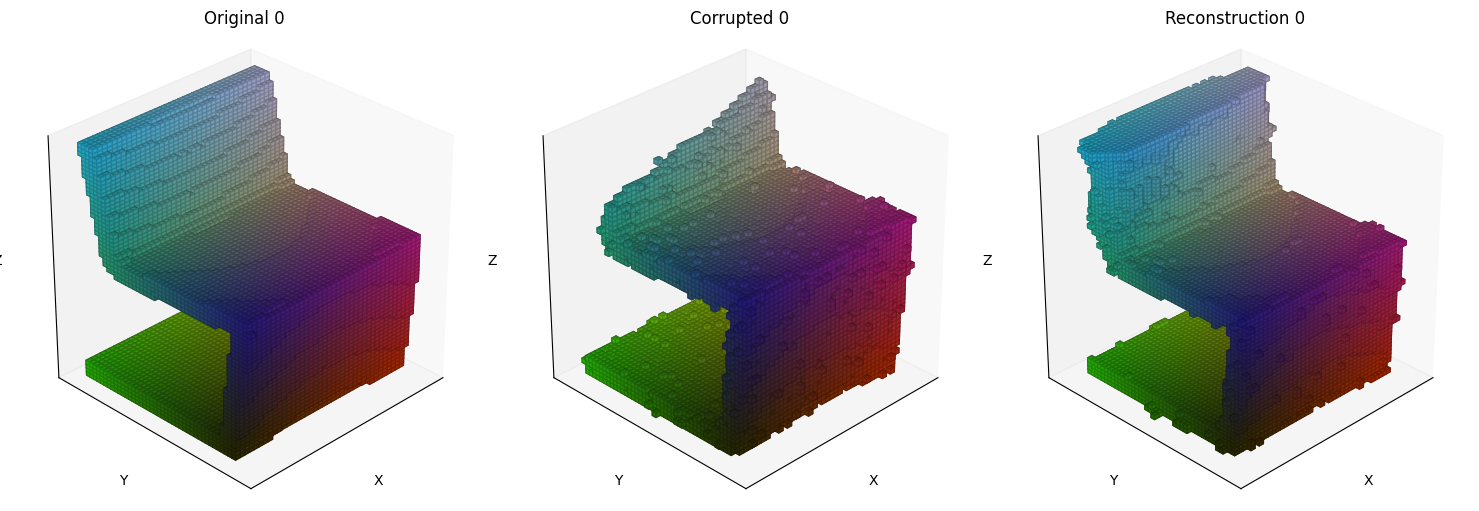

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_voxels_grid(model, test_loader, device="cuda", sample_indices=None, num_examples=3, threshold=0.95):
    """Create a grid of 3D voxel plots with gradient colors"""
    model.eval()
    
    with torch.no_grad():
        # Get all samples from test loader efficiently
        all_samples = next(iter(test_loader))[0]
        if sample_indices is not None:
            data = all_samples[sample_indices].to(device)
            num_examples = len(sample_indices)
        else:
            data = all_samples[:num_examples].to(device)
        
        # Create corrupted versions
        corrupted = apply_random_plane_cut(
            apply_noise_to_voxels(data)
        ).to(device)
        
        # Get reconstructions
        reconstructions = model(corrupted)
        
        # Move to CPU and convert to numpy
        originals = data.cpu().numpy()
        corrupted = corrupted.cpu().numpy()
        reconstructions = (reconstructions.cpu().numpy() > threshold)
        
        # Create figure
        fig = plt.figure(figsize=(15, 5*num_examples))
        
        # Create color gradients
        def create_color_gradient(shape):
            x, y, z = np.indices(shape)
            # Normalize coordinates
            x = x / shape[0]
            y = y / shape[1]
            z = z / shape[2]
            
            # Create RGBA arrays
            colors = np.zeros((*shape, 4))
            colors[..., 0] = x  # Red channel
            colors[..., 1] = y  # Green channel
            colors[..., 2] = z  # Blue channel
            colors[..., 3] = 0.8  # Alpha channel
            
            # Create darker edge colors
            edge_colors = np.zeros((*shape, 4))
            edge_colors[..., 0] = x * 0.7  # Darker red
            edge_colors[..., 1] = y * 0.7  # Darker green
            edge_colors[..., 2] = z * 0.7  # Darker blue
            edge_colors[..., 3] = 0.8  # Alpha channel
            
            return colors, edge_colors
        
        # Pre-compute colors for all plots
        colors, edge_colors = create_color_gradient(
            (originals.shape[2], originals.shape[3], originals.shape[4])
        )
        
        for i in range(num_examples):
            # Original
            ax1 = fig.add_subplot(num_examples, 3, i*3 + 1, projection='3d')
            filled = originals[i, 0]
            ax1.voxels(filled, facecolors=colors, edgecolors=edge_colors)
            ax1.set_title(f'Original {sample_indices[i] if sample_indices else i+1}')
            
            # Corrupted
            ax2 = fig.add_subplot(num_examples, 3, i*3 + 2, projection='3d')
            ax2.voxels(corrupted[i, 0], facecolors=colors, edgecolors=edge_colors)
            ax2.set_title(f'Corrupted {sample_indices[i] if sample_indices else i+1}')
            
            # Reconstruction
            ax3 = fig.add_subplot(num_examples, 3, i*3 + 3, projection='3d')
            ax3.voxels(reconstructions[i, 0], facecolors=colors, edgecolors=edge_colors)
            ax3.set_title(f'Reconstruction {sample_indices[i] if sample_indices else i+1}')
            
            # Set consistent viewing angle and style for all plots
            for ax in [ax1, ax2, ax3]:
                ax.view_init(elev=30, azim=225)
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.grid(False)
                ax.set_box_aspect([1, 1, 1])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    model_path = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/best_model_uNet_chairs_bcelogits.pth"
    data_dir = "C:/Users/naido/Documents/ChalmersCourses/AML/Project/Code/Autoencoder/voxel60"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model = VoxelUNetAutoencoder(resolution=checkpoint['resolution'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Get data loader
    _, test_loader = get_dataloaders(
        data_dir,
        batch_size=1,  # Larger batch size for faster loading
        class_name="chair"
    )
    
    # Visualize specific samples (e.g., samples 3, 10, and 51)
    interesting_samples = [0]#[7, 10, 51]  # These were noted as good examples
    plot_3d_voxels_grid(
        model, 
        test_loader, 
        device=device, 
        sample_indices=interesting_samples
    )